<a href="https://colab.research.google.com/github/shawar8/Object-Detection-Tracking-with-dlib/blob/master/dlib_dog_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('./drive/My Drive/dlib_dog_tracking')

In [12]:
import cv2
import imageio
import imutils
import numpy as np
from scipy.spatial import distance as dist
from collections import OrderedDict
from google.colab.patches import cv2_imshow
import dlib
import math

import smtplib 
from email.mime.multipart import MIMEMultipart 
from email.mime.text import MIMEText 
from email.mime.base import MIMEBase 
from email import encoders 

from details import *

In [13]:
### Creating the to email address, from email address and the password from
### details file
to_address = details['to_address']
from_address = details['from_address']
pwd = details['pwd']

In [14]:
def send_warning_email(from_address, to_address, pwd, filename):
  ### Creating the MIMEMultipart() object as we have an email with text as well
  ### as an image to be attached. Then we specify the different parts of the 
  ### email such as the From, To , Subject, Body and Attachment.
  msg = MIMEMultipart() 
  msg['From'] = from_address
  msg['To'] = to_address
  msg['Subject'] = 'WARNING!!!!'
  body = 'Warning!! Your dog has run away from the premises. Find image attached.'
  msg.attach(MIMEText(body, 'plain')) 
  attachment = open(filename, "rb") 
  p = MIMEBase('application', 'octet-stream') 
  p.set_payload((attachment).read()) 
  encoders.encode_base64(p) 
  p.add_header('Content-Disposition', "attachment; filename= %s" % filename) 
  msg.attach(p) 
  ### SMTP is a library that helps send emails preferably through gmail. 
  ### Make sure to create a dummy email account as it requires you to give 
  ### permissions to outside apps to gain access to your email.
  s = smtplib.SMTP('smtp.gmail.com', 587) 
  s.starttls()
  s.login(from_address, pwd)
  text = msg.as_string() 
  
  s.sendmail(from_address, to_address, text) 
  s.quit()

In [15]:
### Loading the MobileNetSSD pretrained model and weights
protxt_path = 'MobileNetSSD_deploy.prototxt'
model_path = 'MobileNetSSD_deploy.caffemodel'

In [16]:
### List of classes the mobilessdnet was trained on. Make sure the list is
### in order. If using another pre-trained model, make sure the list conforms 
### to the order of that model
classes = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
### Loading the model
net = cv2.dnn.readNetFromCaffe(protxt_path, model_path)

In [ ]:
'''In the following cell, we're going to read the video, run our object detector 
every 10 frames to find the dog, and then run the tracker for all the frames inbetween.
We are also going to save the history of the coordinates of the dog and check if it
is running towards the fence. If at any point we find that the coordinates seem to 
be moving towards the fence, and the centre of the dog has crossed the fence, 
we will save the frame as the filename variable specified. This file will be used
as an attachment to be sent along with the email warning us that the dog has 
exited the premises.'''

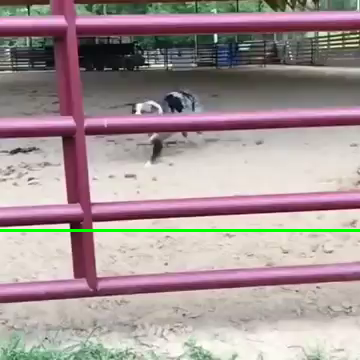

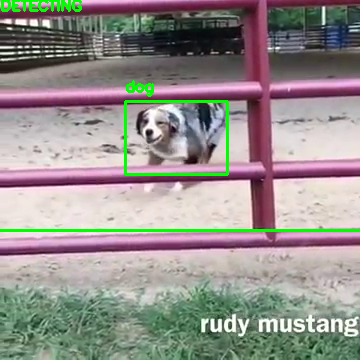

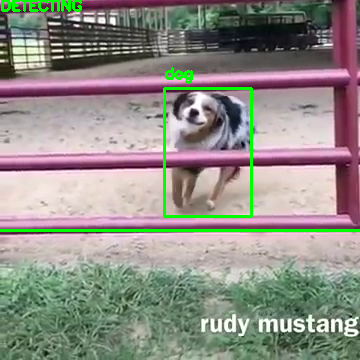

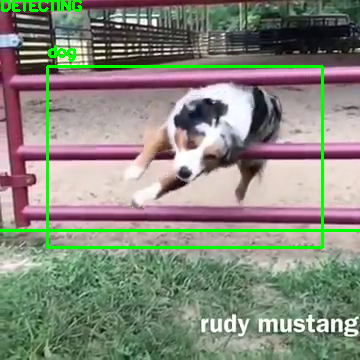

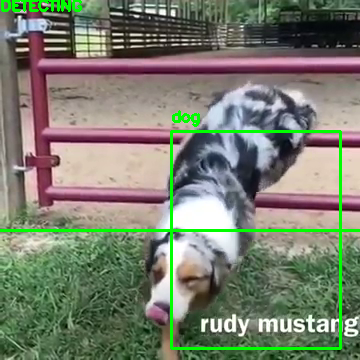

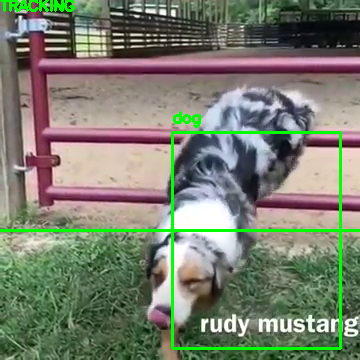

In [17]:
vc = cv2.VideoCapture('dog.mp4')  ### Loading the Video
filename = 'dog_escape.jpg' ### Specifying the filename for the frame in which the dog exits the fence
writer = imageio.get_writer('dog_output.mov') ### Initializing our video writer object
frame_num = 0
detect_frame = 10
trackers = [] ### Tracker list to store the coordinates of the dog
labels = []
tracked = False ### Initialized as False, this will change to True when the dog 
                ### has exited the premises. This is done so that 
                ### we do not get notifications repeatedly
while True:
  ret, frame = vc.read()
  if not ret:
    break
  else:
    h,w = frame.shape[:2]
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  ### We need the rgb version of the image because dlib reads images in thergb convention
    cv2.line(frame, (0, 230), (w, 230), (0,255,0), 2) ### Line defining the exit barrier of the fence
    if frame_num % detect_frame == 0 or len(trackers) == 0: ### Condition to run the object detector
      trackers = [] ### When the running the object detector again, it should overwrite the existing list of trackers
      objects = OrderedDict() ### To keep a track of the corrdinates of the dog
      blob = cv2.dnn.blobFromImage(frame, 0.007843, (w,h), 127.5) ### For more details on this function -> https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
      net.setInput(blob)
      detections = net.forward() ### Detecting the dog
      if len(detections) > 0:
        i = np.argmax(detections[0,0,:,2]) ### Finding the most confident detection, in this case, the dog
        confidence = detections[0,0,i,2] ### Getting the confidence level of the detection so that we dont look at weak detections
        class_ = classes[int(detections[0,0,i,1])] ### To get the actual class of the detection
        if confidence > 0.3 and class_ == 'dog':
          box = detections[0,0,i,3:7] * np.array([w,h,w,h]) ### Defining the coordinates of the detection
          x1,y1,x2,y2 = box.astype('int')
          tracker = dlib.correlation_tracker() ### Defining the tracker
          rect = dlib.rectangle(x1,y1,x2,y2)
          tracker.start_track(rgb, rect) ### Starting our tracker
          center = (int((x1+x2)/2), int(y1+y2)/2)
          objects[i] = [center]  ### Defining the center of the detection and appending it to the objects dict
          ### Drawing the rectangle around the dog, printing the class
          cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
          cv2.putText(frame, class_, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
          cv2.putText(frame, 'DETECTING', (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
          trackers.append(tracker)
          labels.append(class_)
    else:
        tracker.update(rgb) ### Updating the position of the detection
        pos = tracker.get_position() ### Extracting the new position of the object
        x1,y1,x2,y2 = int(pos.left()), int(pos.top()), int(pos.right()), int(pos.bottom()) ### Extracting the new coordinates of the dog
        center = (int((x1+x2)/2), int(y1+y2)/2)
        avg_y = np.array([ct[1] for ct in objects[i]]).mean() ### Finding out the average position of the dog prior to this 
        objects[i].append(center)
        current_y = center[1] ### Extracting the current center point of the dog
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(frame, labels[i], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(frame, 'TRACKING', (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        ### If the dog is consistently moving downwards and is the first instance of it crossing the gate,
        ### then make a copy of the file, send it to the provided email id and mark the dog as marked, so that 
        ### it doesnt send emails repeatedly
        if current_y > avg_y and current_y >= 230 and tracked == False:
          imageio.imwrite(filename, rgb)
          send_warning_email(from_address, to_address, pwd, filename)
          tracked = True
          cv2_imshow(frame)
  ### Show image after every 50 iterations
  if frame_num % 50 == 0:
    cv2_imshow(frame)     
  writer.append_data(cv2.cvtColor(frame,cv2.COLOR_RGB2BGR))
  frame_num += 1
    
vc.release()
writer.close()